# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
import time
from collections import deque
import torch
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
import pickle

%load_ext autoreload
%autoreload 2

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    steps = 0
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        steps += 1
        if np.any(dones):                                  # exit loop if episode finished
            print('steps per episode: {}'.format(steps))
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

steps per episode: 15
Score (max over agents) from episode 1: 0.0
steps per episode: 50
Score (max over agents) from episode 2: 0.19000000320374966
steps per episode: 14
Score (max over agents) from episode 3: 0.0
steps per episode: 14
Score (max over agents) from episode 4: 0.0
steps per episode: 15
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Approach

I am taking two different approaches to solve this problem. First approach is to use two independent DDPG agents for training. I'd expect this to perform poorly (more thoughts below), but it would be interesting to see it in reality. The second approach is to use one single DDPG agent to act for both agents. This should be faster and more robust in terms of training.

#### DDPG setup
In both the approaches I am using identical DDPG setup. So before going into the two approaches, let's specify our network:
* [DDPG](https://arxiv.org/abs/1509.02971) consists of two networks. The actor network takes in the state, and output the action (from continuous space). And the critic network takes in the state and the action to estimate the state-action value function. Note that this is different from the DQN network where the input is the state and output is the Q values of all the actions. The critic network here takes in the action as well and output only one single Q value for the state-action pair.

* For this problem, we use a relatively simple network with only a few small fully connected hidden layers to start with. The reason is because the game itself is relatively simple. The racket just have to learn to hit the ball with the correct positioning and velocity. A simple neutral network should be sufficient to capture the required dynamics.

* For the critic network, we have introduced a batch norm layer for the state input before concatenating the state with the action. This serves as a sort of embedding and lets the network to learn how best to combine the state input and the action input.

* For the actor network, we used a tanh activation function at the final layer as the output action space are all between 1 and -1

* Replay buffer is used to randomly sample the experience and this helps breaking the correlation between consecutive samples. This also make the train more data efficient as we don't throw away the data immediately.

* To further stablizes the training, we have also introduced target actor and critic networks, which are moving slower than the corresponding local networks. The local networks are responsible for making the actual action recommendations, but the target networks are used for backprop-ing the network. This bifurcation stablizes the training process as we won't be chasing a fast moving target. The target network is soft updated by a moving avg of the local parameters. This is basically the same idea as the [Double DQN](https://arxiv.org/abs/1509.06461) network.

#### Challenges

* The main challenge of solving the problem is hyperparamter tuning:
    * actor and critic learning rates, weight decays
    * TAU for soft updating the target network
    * GAMMA for discounting future rewards
    * Noise level, and noise decay rate
    
* I actually tried to start from scratch but after spending a few days trying out different combinations I still had no luck coming up with good model performance. In the end I had to fall back to the default parameters provided as part of the class material.

* Specifially I tried to use different settings for the OU noise but somehow none of the configurations I tried work. I in the end went back to a Gaussian noise. This latter option somehow worked althought theoretically I would expect Gaussian to not work as well for problems with continuous action space - the noise could be averaged out to zero across steps. But anyway it works and that's why I am keeping it.

* Another challenge is that even with reasonable hyperparameters, the training itself is highly unstable. The score can go and up down by a lot between episodes for no obvious reasons. It makes the model developer's job very difficult. I suppose a better fine tuning of the learning rates etc may help to retain the good performance but I couldn't figure that out yet.

### Approach 1: Two Independent DDPG Models for Each Agent
This approach is expected to perform poorly but it is still very interesting to learn from what happened. 

* This is expected to be a bad approach because the two agents are each part of the environment to the other agent. This makes the training problem for each of the agent non-stationary. That is, as agent 1 learns, it actually changes the learning environment for agent 2. Therefore there is no theoretical gaurantee that we can find a solution at all.

* Another problem with this approach, at least for this particular problem, is that the two agents are dependent on each other to achieve a high training score. Eg, if one agent is already very good at the game and can hit the ball perfectly every time, but the other agent has not learned anything yet and misses the ball all the time, then the max score we can achieve per episodie is only 0.1, ie, 1 hit of the ball by the good agent.

* In other words, the overall training score is always constrained by the weaker agent. And given that the training of each of the agents are themselves quite unstable, it is actually quite difficult to train up both agents together to achieve a high score.

* This actually is what happened in our first training of this approach. Agent 1 learned to hit the ball and achieved a score of 0.1 early on, but the overall score cannot go up further until agent 2 also picks up the same skillset at around episode 2000. Only after both the agents can hit the ball once consistently then the overall score could improve.

* Another observation is that th high score peaks happen to both agents at the same time. This is not a coincident but a necessity. It is because an agent's score can only be high if the other agent is also scoring high. If one of the agents dropped the ball then the episode ends with a low score. This is basically a collaborative game.

* I found the above observation of the dynamics between multiple agents very interesting. Although this is an unnecessary compliation for this problem, I suppose this issue can arise in more general multi-agent RF problems. How to make sure the agents are learning in more or less the same pace may be key to the overall performance.


* For this particular problem, given the two agents are basically doing the same task and trying to pick up the same skillset. We actually can use only one DDPG model to act for both agents. This remove the constraint on the weaker agent, and also remove the possiblility of one agent exploting the other. Anyhow, we should still expect the agent to sometimes get trapped in a local region and cannot improve its score further.

In [14]:
def ddpg_two_agents(agents, n_episodes=1000, target_score=0.5, eps_start=1.0, eps_end=0.01, eps_decay=0.995, filename = ""):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        filename (string): filename to save the model parameters
    """
    high_score = 0
    scores = []                         # list containing scores from each episode
    scores_per_agent = [[], []]
    scores_rolling = deque(maxlen=100)  # last 100 max scores 
    times = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = np.zeros(2)
        time1 = time.time()
        
        while True:
            actions = np.array([agent.act(state, eps)[0] for agent, state in zip(agents,states)])
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            for i in range(2):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            states = next_states
            score += rewards
            if any(dones):
                break 
                
        eps = max(eps_end, eps * eps_decay)
        for i in range(2):
            scores_per_agent[i].append(score[i])
        
        max_score = max(score)
        time2 = time.time()
        scores_rolling.append(max_score)      # save most recent score
        scores.append(max_score)              # save most recent score
        times.append(time2-time1)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tRolling Score: {:.4f}\tAverage Time: {:.2f}\tBest Score Saved: {:.4f}'.format(i_episode, np.mean(scores_rolling), np.mean(times),high_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tRolling Score: {:.4f}\tAverage Time: {:.2f}\tBest Score Saved: {:.4f}'.format(i_episode, np.mean(scores_rolling), np.mean(times),high_score))
            
        # Avg rolling scores
        avg_score = np.mean(scores_rolling)    # max score
        
        if avg_score>=high_score:
            #saving model
            save_dict_list =[]
            save_dict = {'actor_local1' : agents[0].actor_local.state_dict(),
                         'actor_target1': agents[0].actor_target.state_dict(),
                         'critic_local1' : agents[0].critic_local.state_dict(),
                         'critic_target1' : agents[0].critic_target.state_dict(),
                         'actor_local2' : agents[1].actor_local.state_dict(),
                         'actor_target2': agents[1].actor_target.state_dict(),
                         'critic_local2' : agents[1].critic_local.state_dict(),
                         'critic_target2' : agents[1].critic_target.state_dict(),
                        }
            save_dict_list.append(save_dict)

            torch.save(save_dict_list, filename + ".pth")
            high_score = avg_score
            
            if avg_score > target_score:
                break
            
    return scores, scores_per_agent

#### Training two independent DDPG agents

In [15]:
agents1 = [ Agent(state_size, action_size, seed=3), Agent(state_size, action_size, seed=18) ]
results_two_agents1 = ddpg_two_agents(agents1, n_episodes=20000, target_score=0.5, filename = "ddpg_two_agents1")

Episode 100	Rolling Score: 0.0010	Average Time: 0.10	Best Score Saved: 0.0083
Episode 200	Rolling Score: 0.0075	Average Time: 0.11	Best Score Saved: 0.0083
Episode 300	Rolling Score: 0.0000	Average Time: 0.10	Best Score Saved: 0.0083
Episode 400	Rolling Score: 0.0246	Average Time: 0.13	Best Score Saved: 0.0246
Episode 500	Rolling Score: 0.0341	Average Time: 0.14	Best Score Saved: 0.0446
Episode 600	Rolling Score: 0.0107	Average Time: 0.12	Best Score Saved: 0.0446
Episode 700	Rolling Score: 0.0088	Average Time: 0.11	Best Score Saved: 0.0446
Episode 800	Rolling Score: 0.0049	Average Time: 0.11	Best Score Saved: 0.0446
Episode 900	Rolling Score: 0.0040	Average Time: 0.11	Best Score Saved: 0.0446
Episode 1000	Rolling Score: 0.0058	Average Time: 0.11	Best Score Saved: 0.0446
Episode 1100	Rolling Score: 0.0150	Average Time: 0.12	Best Score Saved: 0.0446
Episode 1200	Rolling Score: 0.0290	Average Time: 0.14	Best Score Saved: 0.0446
Episode 1300	Rolling Score: 0.0400	Average Time: 0.15	Best Sc

Episode 10400	Rolling Score: 0.1630	Average Time: 0.47	Best Score Saved: 0.4506
Episode 10500	Rolling Score: 0.2941	Average Time: 0.84	Best Score Saved: 0.4506
Episode 10600	Rolling Score: 0.2828	Average Time: 0.83	Best Score Saved: 0.4506
Episode 10700	Rolling Score: 0.2573	Average Time: 0.80	Best Score Saved: 0.4506
Episode 10800	Rolling Score: 0.1882	Average Time: 0.58	Best Score Saved: 0.4506
Episode 10900	Rolling Score: 0.1558	Average Time: 0.48	Best Score Saved: 0.4506
Episode 11000	Rolling Score: 0.1861	Average Time: 0.57	Best Score Saved: 0.4506
Episode 11100	Rolling Score: 0.1697	Average Time: 0.50	Best Score Saved: 0.4506
Episode 11200	Rolling Score: 0.2000	Average Time: 0.62	Best Score Saved: 0.4506
Episode 11300	Rolling Score: 0.1430	Average Time: 0.48	Best Score Saved: 0.4506
Episode 11400	Rolling Score: 0.1744	Average Time: 0.55	Best Score Saved: 0.4506
Episode 11500	Rolling Score: 0.1453	Average Time: 0.45	Best Score Saved: 0.4506
Episode 11600	Rolling Score: 0.2122	Aver

In [16]:
file = open('results_two_agents1.pkl', 'wb')
pickle.dump(results_two_agents1, file)
file.close()

In [17]:
def plot_score(results, title):
    scores, scores_per_agent = results
    
    #plt.figure(figsize=(12, 8), dpi=80)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))
    fig.suptitle(title)
    
    # max score
    rolling=pd.Series(scores).rolling(100).mean()
    ys = 0.*np.array(scores) + 0.5
    ax1.plot(scores, label='score')
    ax1.plot(rolling, label='rolling avg')
    ax1.plot(ys, 'g-.', label='target')
    ax1.legend()
    ax1.set_ylabel('Max(Agent 1, Agent 2)')
    
    # agent 1
    scores = scores_per_agent[0]
    rolling=pd.Series(scores).rolling(100).mean()
    ys = 0.*np.array(scores) + 0.5
    ax2.plot(scores, label='score')
    ax2.plot(rolling, label='rolling avg')
    ax2.plot(ys, 'g-.', label='target')
    ax2.legend()
    ax2.set_ylabel('Agent 1')
    ax2.set_xlabel('#episodes')
    
    # agent 2
    scores = scores_per_agent[1]
    rolling=pd.Series(scores).rolling(100).mean()
    ys = 0.*np.array(scores) + 0.5
    ax3.plot(scores, label='score')
    ax3.plot(rolling, label='rolling avg')
    ax3.plot(ys, 'g-.', label='target')
    ax3.legend()
    ax3.set_ylabel('Agent 2')
    ax3.set_xlabel('#episodes')

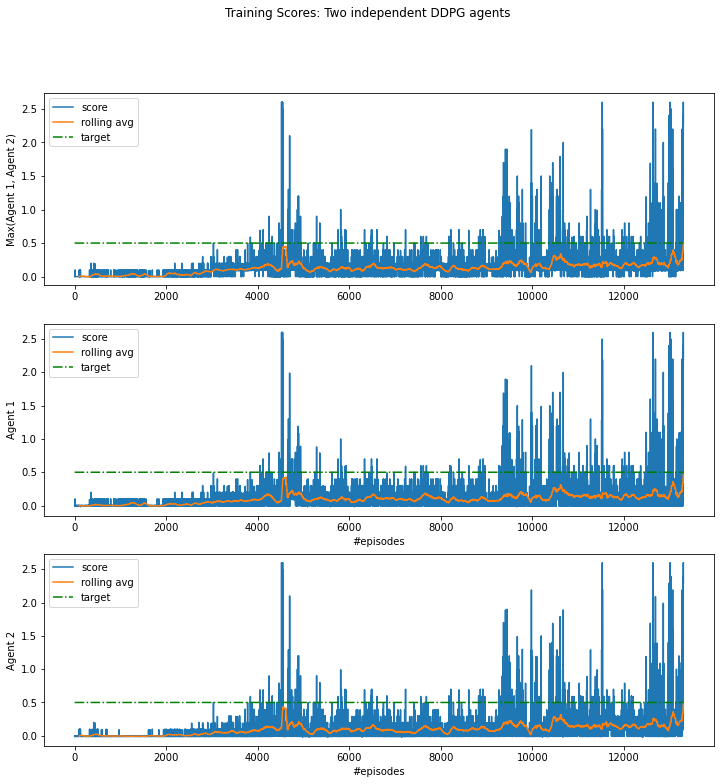

In [21]:
plot_score(results_two_agents1, "Training Scores: Two independent DDPG agents")

### Approach 2: One Single DDPG Agent for Both Agents

* Given the two agents in the problem are essentially doing the same task, it makes sense to train only one DDPG model to act for both agents. In fact, given that the observation for each agent already contains both the racket's and the ball's positions and velocities. One could argue that we do not need a MADDPG here, ie, the observation from the other agent is not really adding much value to the training process.

* Below shows a sample run of the DDPG that hits the benchmark score of 0.5 in 5100 episodes. This seems to be much better than having two independent agents (approach 1 above) which took 13000 episodes. However, we cannot really make a concrete comparison of the performances of the two approaches unless we run more instances and average out the sampling noises.

* This is by no mean a good performance. There are [models](https://github.com/silviomori/udacity-deep-reinforcement-learning-p3-collab-compet/blob/master/Tennis.ipynb) that solve the problem within 1000 episodes. But even after studying their parameters qutie a bit, I couldn't really figure out conceptually what is driving the performance difference.

In [5]:
def ddpg_one_agent(agent, n_episodes=1000, target_score=0.5, eps_start=1.0, eps_end=0.01, eps_decay=0.995, filename = ""):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        filename (string): filename to save the model parameters
    """
    high_score = 0
    scores = []                         # list containing scores from each episode
    scores_rolling = deque(maxlen=100)  # last 100 scores
    times = deque(maxlen=100)
    rolling_rewards = deque(maxlen=10000) # to keep track of the reward statistics
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = np.zeros(2)
        time1 = time.time()
        
        while True:
            actions = np.array([agent.act(state, eps)[0] for state in states])
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            for i in range(2):
                if rewards[i] > 0:
                    n = 1
                else:
                    n = 1
                    
                for _ in range(n):
                    agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
                    
                rolling_rewards.append(rewards[i])
            states = next_states
            score += rewards
            if any(dones):
                break 
                
        eps = max(eps_end, eps * eps_decay)
        max_score = max(score)
        time2 = time.time()
        scores_rolling.append(max_score)      # save most recent score
        scores.append(max_score)              # save most recent score
        times.append(time2-time1)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        pos_reward_pct = len([x for x in rolling_rewards if x > 0]) / len(rolling_rewards)
        print('\rEpisode {}\tRolling Score: {:.4f}\tAverage Time: {:.2f}\tBest Score Saved: {:.4f}\tPositive Reward(%): {:.4f}'.format(\
            i_episode, np.mean(scores_rolling), np.mean(times), high_score, pos_reward_pct), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tRolling Score: {:.4f}\tAverage Time: {:.2f}\tBest Score Saved: {:.4f}\tPositive Reward(%): {:.4f}'.format(\
                i_episode, np.mean(scores_rolling), np.mean(times),high_score, pos_reward_pct))
        avg_score = np.mean(scores_rolling)
        
        if avg_score>=high_score:
            #saving model
            save_dict_list =[]
            save_dict = {'actor_local' : agent.actor_local.state_dict(),
                         'actor_target': agent.actor_target.state_dict(),
                         'critic_local' : agent.critic_local.state_dict(),
                         'critic_target' : agent.critic_target.state_dict()}
            save_dict_list.append(save_dict)

            torch.save(save_dict_list, filename + ".pth")
            high_score = avg_score
            
            if avg_score > target_score:
                break
            
    return scores

In [6]:
agent1 = Agent(state_size, action_size, seed=308)
scores_one_agent1=ddpg_one_agent(agent1, n_episodes=20000, target_score=0.5, filename = "ddpg_one_agent1")

Episode 100	Rolling Score: 0.0009	Average Time: 0.10	Best Score Saved: 0.0450	Positive Reward(%): 0.0003
Episode 200	Rolling Score: 0.0000	Average Time: 0.10	Best Score Saved: 0.0450	Positive Reward(%): 0.0002
Episode 300	Rolling Score: 0.0000	Average Time: 0.10	Best Score Saved: 0.0450	Positive Reward(%): 0.0001
Episode 400	Rolling Score: 0.0000	Average Time: 0.10	Best Score Saved: 0.0450	Positive Reward(%): 0.0000
Episode 500	Rolling Score: 0.0000	Average Time: 0.10	Best Score Saved: 0.0450	Positive Reward(%): 0.0000
Episode 600	Rolling Score: 0.0000	Average Time: 0.10	Best Score Saved: 0.0450	Positive Reward(%): 0.0000
Episode 700	Rolling Score: 0.0000	Average Time: 0.10	Best Score Saved: 0.0450	Positive Reward(%): 0.0000
Episode 800	Rolling Score: 0.0028	Average Time: 0.11	Best Score Saved: 0.0450	Positive Reward(%): 0.0003
Episode 900	Rolling Score: 0.0010	Average Time: 0.10	Best Score Saved: 0.0450	Positive Reward(%): 0.0004
Episode 1000	Rolling Score: 0.0010	Average Time: 0.10	B

In [7]:
file = open('scores_one_agent1.pkl', 'wb')
pickle.dump(scores_one_agent1, file)
file.close()

Text(0.5, 0, '#episodes')

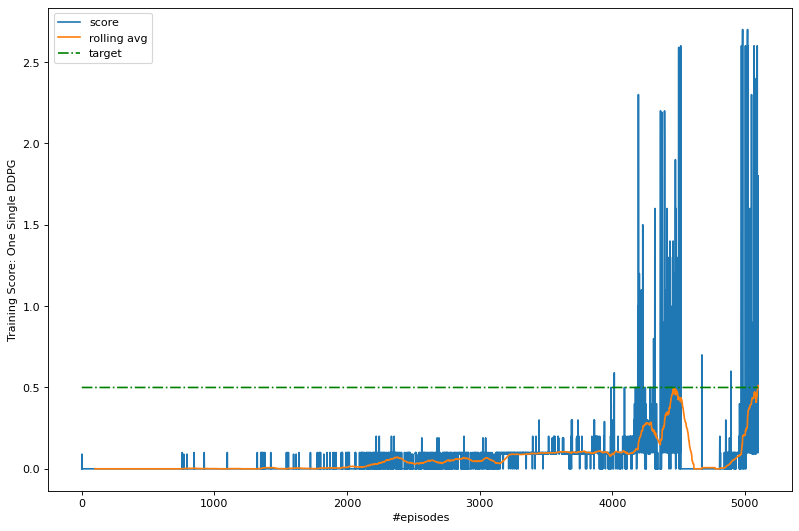

In [20]:
figure(figsize=(12, 8), dpi=80)
rolling=pd.Series(scores_one_agent1).rolling(100).mean()
ys = 0.*np.array(scores_one_agent1) + 0.5
plt.plot(scores_one_agent1, label='score')
plt.plot(rolling, label='rolling avg')
plt.plot(ys, 'g-.', label='target')
plt.legend()
plt.ylabel('Training Score: One Single DDPG')
plt.xlabel('#episodes')

### Potential Enhancements

There is a lot that I would like to try out as next steps:
* Implement MADDPG where the agents share the critic, and the critic network takes in all agents' observations and actions during training.

* Figure out how to fine tune the OU noise correctly to solve the problem quickly. What I realized with my experimentations is that the noise level and how it decay plays a huge role in how the model behave and converge. A properly tuned noise encourages the model to do the right level of exploration, which is essentially especially in the early stage of training.

* Learn more about hyperparameter tuning in general. I found this [paper](https://arxiv.org/abs/2006.05990) which details lots of insights from running lots of RF experiments, would like to try out some of the ideas here.

* Another challenge in solving this problem is that the portion of positive reward experience is quite low. It started with <1% to ~25% when fully trained. Implementing [prioried experience replay](https://arxiv.org/abs/1511.05952) should help to extract more performance out of the data points with positive rewards and help converge faster.